## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

sys.path.append("..")
from MLP_utils.utils import parameter_set
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)


sys.path.append("../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use


file_path = Path(
    "../../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)

file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()
# df = pd.read_csv(file_path, engine="pyarrow")

In [3]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [4]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
# df = df.assign(
#     Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
#     + "_"
#     + df["Metadata_dose"]
# )

# print("Unique Catagories are:")
# print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df specific to analysis and model
# df = df.query(
#     "oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_DMSO_0.025'| oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_10.000_DMSO_0.025'"
# )
# for binary classification testing
df = df.query(
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_DMSO_0.025'| oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025'"
)
print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
# Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# Check for Nans again
df_stats(df)

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'LPS_100.000_DMSO_0.025']
The dimensions of the data are: (51630, 2872)
Number of total missing values across all columns: 103260
Data Subset Is Off


In [5]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'J21']
Wells to use for training, validation, and testing ['B14' 'C14' 'B15' 'C15' 'J14' 'I15' 'J15' 'J16' 'J17' 'J20']


In [6]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [7]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

##### Regression Model Data Wrangling and Set Up
comment out if not using regression

In [8]:
# if params.DATA_SUBSET_OPTION == 'True':
#     df = df.sample(n=params.DATA_SUBSET_NUMBER)
#     print("yes")
# else:
#     pass
# df_stats(df)
# # Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# # Check for Nans again
# df_stats(df)
# # Code snippet for metadata extraction by Jenna Tomkinson
# df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])
# # define which columns are data and which are descriptive
# df_descriptive = df[df_metadata]
# df_values = df.drop(columns=df_metadata)
# df_values_Y = df_values['Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256']
# df_values_X = df_values.drop('Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256', axis=1)

#### Split Data - All Models can proceed through this point

In [9]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [10]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [11]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  2847
Number of out features:  2
Binary_Classification


In [12]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [13]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    pass


# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-05-05 10:35:23,781] A new study created in memory with name: no-name-996cc0f0-ef22-49e9-9243-56e70c8a697c
[I 2023-05-05 10:36:12,129] Trial 0 finished with value: 0.2700458128452301 and parameters: {'n_layers': 1, 'n_units_l0': 6, 'dropout_0': 0.14649243945150242, 'learning_rate': 0.005488830163992854, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.2700458128452301.
[I 2023-05-05 10:36:58,675] Trial 1 finished with value: 0.10684562391042711 and parameters: {'n_layers': 1, 'n_units_l0': 6, 'dropout_0': 0.2416179148160178, 'learning_rate': 0.010684244600355436, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.10684562391042711.
[I 2023-05-05 10:37:45,113] Trial 2 finished with value: 0.21290932762622833 and parameters: {'n_layers': 2, 'n_units_l0': 5, 'dropout_0': 0.2191950072456154, 'n_units_l1': 5, 'dropout_1': 0.12410106006641021, 'learning_rate': 0.09516707025881221, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.10684562391042711.
[I 2023-05-05 10:38:31,780] Tri

Validation Accuracy: 96.48183735645652
Validation Loss: 0.11575690832734108
Training Accuracy: 95.3270442094161
Training Loss: 0.11325230386640345


(96.48183735645652, 0.11575690832734108, 95.3270442094161, 0.11325230386640345)

In [14]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = Path(f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_optimization_history_graph"
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [15]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = Path(f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = (
    f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_intermediate_values_graph"
)
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [16]:
param_dict = extract_best_trial_params(
    study.best_params, params, model_name=params.MODEL_NAME
)

In [17]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
    params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam
Epoch 0: Validation loss decreased (inf --> 0.199732).  Saving model ...
	 Train_Loss: 0.3510 Train_Acc: 81.806 Val_Loss: 0.1997  BEST VAL Loss: 0.1997  Val_Acc: 92.337

Epoch 1: Validation loss decreased (0.199732 --> 0.170468).  Saving model ...
	 Train_Loss: 0.2882 Train_Acc: 87.487 Val_Loss: 0.1705  BEST VAL Loss: 0.1705  Val_Acc: 94.821

Epoch 2: Validation loss decreased (0.170468 --> 0.156746).  Saving model ...
	 Train_Loss: 0.2539 Train_Acc: 88.844 Val_Loss: 0.1567  BEST VAL Loss: 0.1567  Val_Acc: 95.219

Epoch 3: Validation loss decreased (0.156746 --> 0.146634).  Saving model ...
	 Train_Loss: 0.2331 Train_Acc: 91.548 Val_Loss: 0.1466  BEST VAL Loss: 0.1466  Val_Acc: 95.172

Epoch 4: Validation loss decreased (0.146634 --> 0.141429).  Saving model ...
	 Train_Loss: 0.2175 Train_Acc: 93.083 Val_Loss: 0.1414  BEST VAL Loss: 0.1414  Val_Acc: 95.149

Epoch 5: Validation loss decreased (0.141429 --> 0.136516).  Saving model ...
	 Train_Loss: 0.2057 Train_Acc: 93.455 Val_Loss

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:962: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:963: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



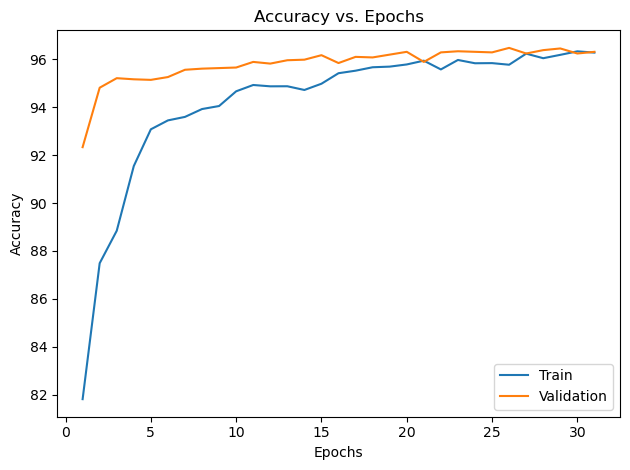

In [18]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:962: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:963: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



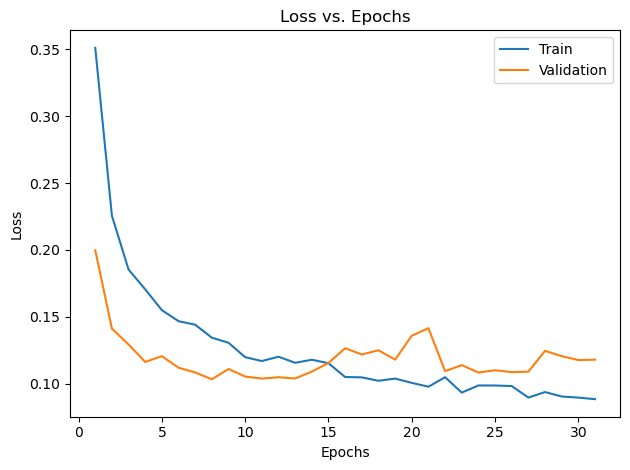

In [19]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
)

In [20]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3081
           1       0.92      0.94      0.93      1186

    accuracy                           0.96      4267
   macro avg       0.95      0.95      0.95      4267
weighted avg       0.96      0.96      0.96      4267



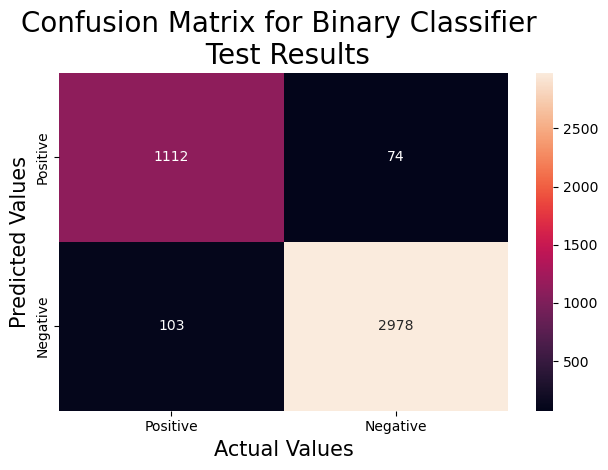

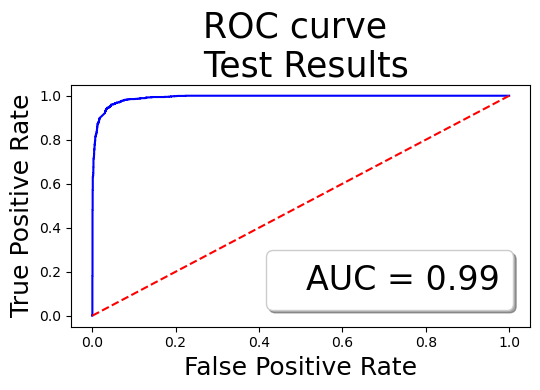

In [21]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

#### look at the feature weights of the model

In [22]:
# get all paramters from pytorch model
lst = []
for name, param in model.named_parameters():
    # print(name, param.shape)
    lst.append(param)
feature_weights = model[0].weight.grad[0].detach().cpu().numpy()

In [23]:
col_list = []
for col in df_values.columns:
    # print(col)
    col_list.append(col)

In [24]:
# remove last 4 columns from col_list that are not features
col_list = col_list[:-4]

In [25]:
pd.set_option("display.max_colwidth", None)

df = pd.DataFrame(zip(col_list, feature_weights), columns=["feature", "weight"])
# change weight collumn to float
df["weight"] = df["weight"].astype(float)
# sort by weight
df = df.sort_values(by=["weight"], ascending=False)
df

,feature,weight
63,Cytoplasm_Correlation_Correlation_CorrGasdermin_CorrPM,6.917330e-07
61,Cytoplasm_Correlation_Correlation_CorrER_CorrPM,6.759976e-07
649,Cytoplasm_RadialDistribution_ZernikePhase_CorrMito_9_3,6.018633e-07
1632,Cells_RadialDistribution_ZernikePhase_CorrPM_9_5,5.846112e-07
2019,Nuclei_Correlation_RWC_CorrER_CorrPM,5.748866e-07
...,...,...
1311,Cells_RadialDistribution_MeanFrac_CorrPM_1of4,-6.217981e-07
701,Cytoplasm_Texture_AngularSecondMoment_CorrPM_3_02_256,-6.333309e-07
2064,Nuclei_Granularity_16_CorrGasdermin,-7.019316e-07
167,Cytoplasm_Granularity_16_CorrGasdermin,-7.612460e-07


In [27]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [28]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

In [29]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [30]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4837
           1       0.98      0.86      0.92      4126

    accuracy                           0.93      8963
   macro avg       0.94      0.92      0.93      8963
weighted avg       0.93      0.93      0.93      8963



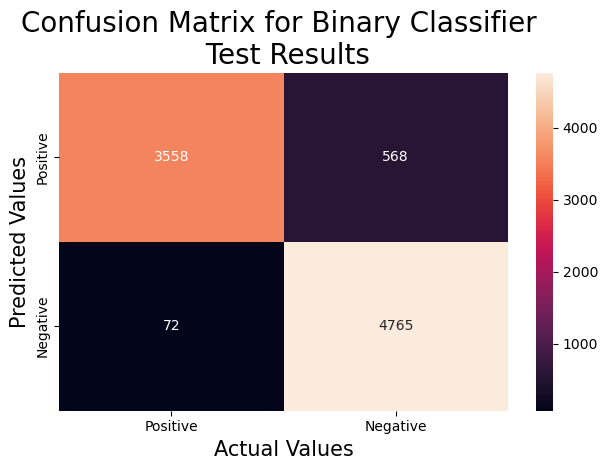

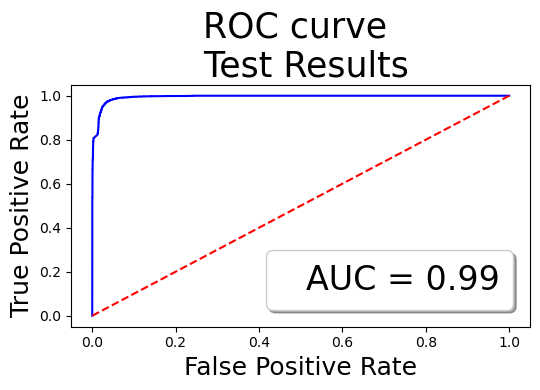

In [31]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")